In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import pyreadr

In [ ]:
def instance_map(variable, year=2020, month=1, choice='all', scale=2, vmin=None, vmax=None, print_range=False, saveto=None):
    valid_admin = pd.read_csv(f'base_info/admin{scale}_unique.csv', header=None)[0].tolist()
    
    # Read shapefile
    admin_shp = gpd.read_file(f"dengue_indonesia_yifan/data/shapefiles/admin{scale}/admin{scale}_38.shp")
    # drop invalid admin2 regions
    admin_shp = admin_shp[admin_shp[f'admin{scale}'].isin(valid_admin)]
    other_shp = gpd.read_file("dengue_indonesia_yifan/data/shapefiles/other/idn_neighbours.shp")

    _ = pd.read_csv('base_info/var_to_file.csv')
    var_to_file_loaded = dict(zip(_['variable'], _['file_name']))
    file = var_to_file_loaded[variable]
    if file[0]=='[':
        file = file.strip("[]").replace("'", "")
        file = [x.strip() for x in file.split(',') if file.strip()]
        if choice=='all':
            file = file[0]
        else:
            file = file[1]
    
    if variable in ['rhumidity', 'rhumidity_pop_weighted',
                    'precipitation_mm', 'precipitation_mm_pop_weighted',
                    'temperature_celsius', 'temperature_celsius_pop_weighted']:
        #substitute the 2 in file with scale
        file = file.replace('2', str(scale))
        d_var = pyreadr.read_r('dengue_indonesia_yifan/data/'+file)[None]
        m_ = [a in valid_admin for a in d_var[f'admin{scale}']]
        d_var = d_var.loc[m_, :]

        df = d_var.loc[d_var['month_year']==f"X{year}.{month:02d}", [f'admin{scale}', variable]]

    elif variable in ['cases', 'deaths']:
        d_var = pyreadr.read_r('dengue_indonesia_yifan/data/'+file)[None]
        m_ = [a in valid_admin for a in d_var[f'admin{scale}']]
        d_var = d_var.loc[m_, :]
        df = d_var.loc[(d_var['year']==year) & (d_var['month']==month), [f'admin{scale}', variable]]
        # sum over multiple entries per admin region
        df = df.groupby(f'admin{scale}', as_index=False).sum()

    elif variable in ['surveillance_pop_pct', 'surveillance_area_pct',
                      'urban_pop_pct_binary', 'urban_area_pct_binary']:
        #substitute the 2 in file with scale
        file = file.replace('2', str(scale))
        d_var = pyreadr.read_r('dengue_indonesia_yifan/data/'+file)[None]
        m_ = [a in valid_admin for a in d_var[f'admin{scale}']]
        d_var = d_var.loc[m_, :]

        df = d_var.loc[:, [f'admin{scale}', variable]]


    # merge data on admin column
    admin_ir = admin_shp.merge(df, left_on=f"admin{scale}", right_on=f"admin{scale}", how="left")

    fig, ax = plt.subplots(figsize=(12, 5))

    if print_range:
        print(f"{variable} range: ", admin_ir[variable].min(), " to ", admin_ir[variable].max())
    admin_ir.plot(
        column=variable,   # value to plot
        cmap="viridis",       # same style as your R example 
        # log viridis scale
        # norm=plt.matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax) if (vmin is not None and vmax is not None) else None,

        linewidth=0.2,
        edgecolor="black",
        legend=True,
        vmin=vmin,
        vmax=vmax,
        ax=ax
    )

    other_shp.boundary.plot(ax=ax, color="black", linewidth=0.1)

    time = pd.to_datetime(f"{year}-{month}-01")
    ax.set_title(f"Admin level {scale}: {variable} for {time.strftime('%Y-%m')}", fontsize=10)
    ax.set_axis_off()

    # define plot boundaries
    minx, miny, maxx, maxy = admin_ir.total_bounds
    ax.set_xlim(minx - 1, maxx + 1)
    ax.set_ylim(miny - 1, maxy + 1)

    if saveto:
        plt.savefig(saveto, bbox_inches='tight', dpi=300)

    plt.show()

cases range:  0.0  to  620.0


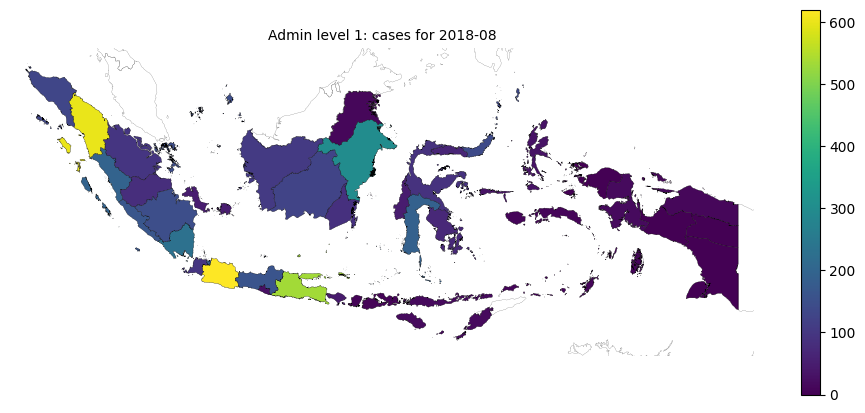

In [ ]:
instance_map('cases', year=2018, month=8, scale=1, saveto=None, print_range=True)